##### imports + initial data loading:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import pandas as pd
from etl.db import NYC311Database
import pickle
from eda import visualizations

pd.set_option("display.max_colwidth", 200)

CSS = """
<style>

h1, h2, h3 { font-family: Inter, Segoe UI, Roboto, Helvetica, Arial; }
h1 { border-bottom: 2px solid #eee; padding: .8rem; }
h2 { margin-top: 2rem; border-left: 4px solid #5c9aff; padding-left: .5rem; }
h3 { color: #555; }


.summary { border: 1px solid #ddd; border-left: 6px solid #5c9aff; padding: 0.8rem 1rem; border-radius: 8px; background: #fafafa; margin: 1rem 0; }
.metric { display:inline-block; margin-right:12px; padding:6px 10px; border-radius:10px; background:#f5f7ff; border:1px solid #dfe3ff; font-weight:600; }


table.dataframe { font-size: 14px; }
</style>
"""
display(HTML(CSS))


In [5]:
with open("model_pickle.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [7]:
!cp nyc311.duckdb nyc311_read.duckdb
db = NYC311Database(False)

<div style="font-family:'Inter',sans-serif; margin-bottom:1.5em;">
  <h1 style="font-size:2.2em; font-weight:700;margin-bottom:0.2em;">
    NYC 311 Service Requests
  </h1>
  <div style="font-size:1.1em; color:#555;">A report to help inform resource allocation</div>
  <div style="height:4px; width:160px; background:#1E90FF; margin-top:10px; border-radius:2px;"></div>
</div>

## Background

<div class="summary">
This report will demonstrate what influences NYC 311 call volumes so that the city can allocate the proper resources before issues occur. 
<br><br>
The ultimate goal is to help the city allocate response resources more effectively. To best show this, I focused on noise complaints in the Bronx. This is the borough with both the highest total complaint volume per resident and the highest density of noise complaints. Zeroing in on this clearly high priority issue allows us to model a concrete, high-impact use case while keeping the approach generalizable. 
<br><br>
<b> End result: </b> predict and identify times of days with <i>significantly high complaint noise volumes</i>
</div>

## High-level summary

<div class="summary">
<span class="metric">Calls per resident (Bronx): <span>5.3</span></span>
<span class="metric">Noise complaints per resident: <span>1.3</span></span>
<span class="metric">Noise % of calls: <span>23%</span></span>
<p>

<b>Complaints:</b> Noise complaints are by far the most frequent 311 call in the Bronx. <br>
<b>Factors influencing noise:</b> Weekends, summer days, nights, and number of calls the week prior lead to more noise complaints. <br>
<b>Recommendation:</b> Staff more police officers in the Bronx on weekends and nights, as well as during the summer months to catch noise violations before 311 is called.
</div>

## Data
- NYC 311 Open Data (2010–now)
- Borough level population (census years and predicted)
  


## Scope of analysis & definitions
- Daily noise complaints, with hour by hour granularity
- Identifying <b>high complaint periods</b> &rarr; complaints in the top <b>30%</b> for a given day and hour
- ***Significantly high complaint volume:*** A time of day having a complaint volume in the 70% percentile.
  - This particular threshold ensures that enough days/times are classified as significant in volume to have a positive impact on the community


## Overall complaint analysis
- The map below considers all complaints across the available data
- While there are clearly many complaints across the entire city, the Bronx and Manhattan have a higher concentration of calls
- Manhattan is the borough with most **total** complaints, but the Bronx has more **complaints per resident**
  - Bronx &rarr; **5.3** complaints per person
  - Manhattan &rarr; **4.9** complaints per person

In [8]:
visualizations.get_nyc_complaint_map(db)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

TypeError: '>' not supported between instances of 'str' and 'int'

- The entire city has seen an uptick in 311 calls over the last 5 years
- The chart below demonstrates the proportion of calls per resident in a given year
- The Bronx has seen a particularly significant increase in 311 calls, while Staten Island has had a large decrease

In [ ]:
visualizations.get_ts_proportions(db)

## Noise complaint analysis
<i>Determining which features are informative</i>

- The heatmap below demonstrates that the Bronx sees the highest number of noise complaints on ***Saturday and Sundays*** from the hours of ***8pm - 2am***.
- The obvious spikes during these times imply that a flag for weekend and nights will reflect days with significant call volumes
- More specifically, weekends make up ***81%*** of all days having a volume of noise complaints indicated as an anomaly and ***62%*** of all noise complaints
  - <i>An anomaly here is defined as having a Z-score two standard deviations outside of the average noise complaint counts </i>

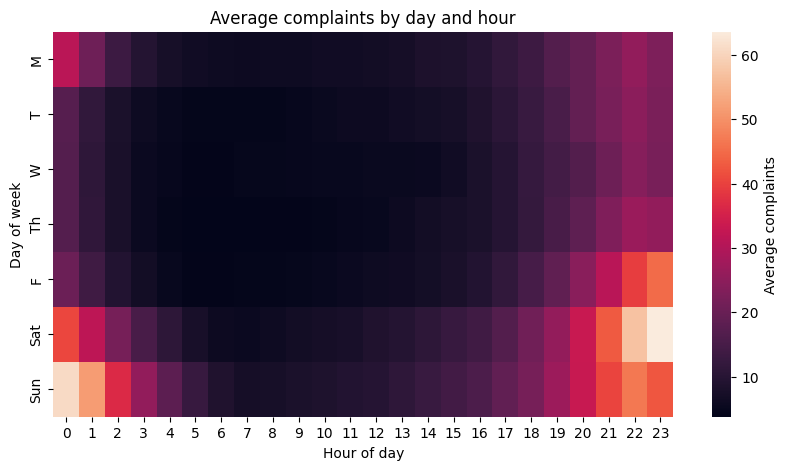

In [17]:
visualizations.get_noise_complaint_heatmap(db)

- In addition to weekends and nights, there is a clear patttern of higher call volumes during ***summer months*** (highlighted as red below)
- In the final predictive model, I include a flag to indicate whether or not the date is in summer (June, July, August, September)
- Summer months make up ***46%*** of all noise complaints in the Bronx

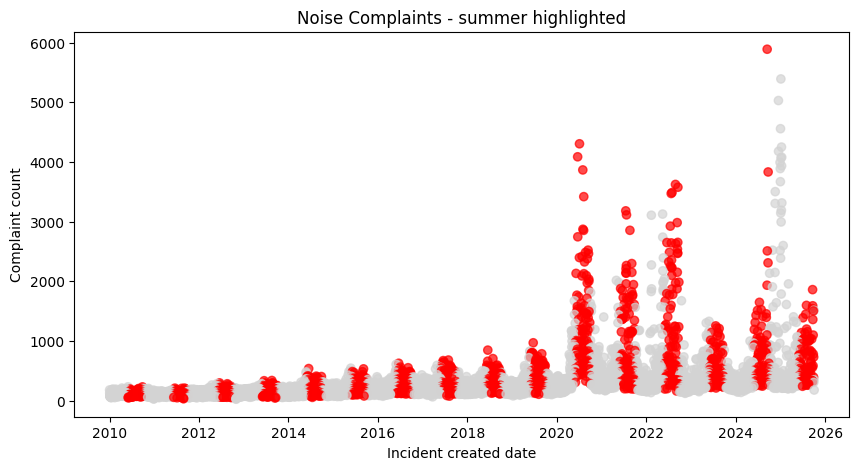

In [28]:
visualizations.highlight_summer_spikes(db)

- The final feature incorporates the count of complaints from 7 days prior
- The Autocorrelation Function (ACF) plot below shows that there is clearly a correlation between today's complaint volume and the week prior
- This is included as an additional feature to capture overall time series patterns in the data to complement the day of week and season-related features prior

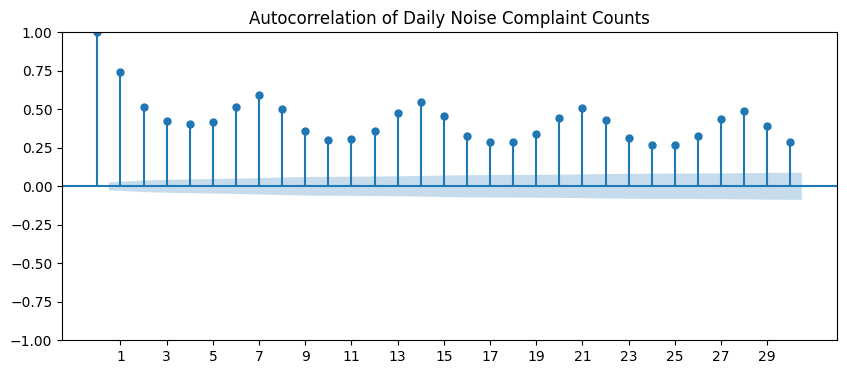

In [29]:
visualizations.get_acf_plot(db)

## Model efficacy & results
- ***Model inputs:*** summer (True/False), weekend (True/False) time of day (morning, afternooon evening), previous week complaint count,
- ***Model output:*** A series of days predicted to have a significant noise complaint volume
- ***Model methodology:*** Logistic regression model, optimized to produce highest precision and recall
  - Precision measures how many predicted high volume days were infact high volume days ("false alarms")
  - Recall measures how many actual high volume days were classified correctly

### Classification accuracy
<span class="metric">Precision: <span>62%</span></span>
<span class="metric">Recall: <span>76%</span></span>
<span class="metric">Area under curve (AUC): <span>84.8%</span></span>
- ***Precision*** measures how many predicted high volume days were infact high volume days ("false alarms")
- ***Recall*** measures how many actual high volume days were classified correctly
- ***AUC*** measures how good the model is when separating high volume days from normal days
  - A value of 100% would be perfect, 50% is a random classifier
<p>
<b>Summary:</b> the above results indicate that our model is able to accurately classify the majority of actual days/times with high noise complaint volumes. This accuracy implies that we can use the results from this model to inform resource allocations. 

- The **confuson matrix** below visualizes how many high complaint days were accurately and inaccurately estimated
- This is another way to see the efficacy of the model
- The model correctly identifies the majority of the actual high complaint days 

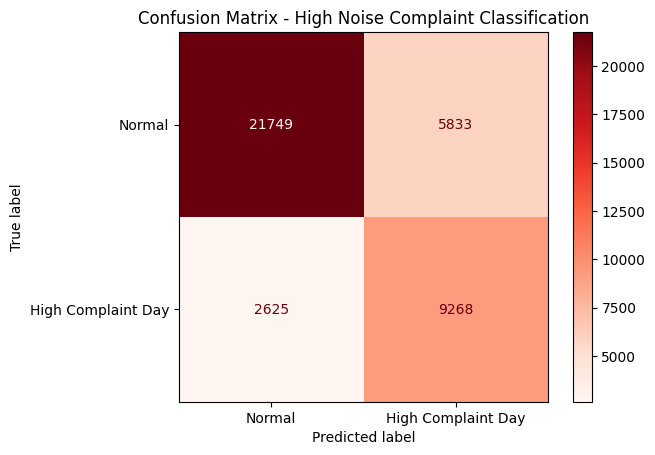

In [30]:
visualizations.get_confusion_matrix(loaded_model['y_data'][1], loaded_model['y_data'][2])

### Feature importance
- The previous model results show that the features selected have good predictive power when identifying noise complaints
- Breaking down the features which had the greatest influence will help to inform when to best allocate resources
- The graph below demonstrates the model's coefficent values
  - A **positive** coefficient implies that the feature **increases** the likelihood of a high noise complaint day. A ne
  - A **negative** coefficient implies that the feature **decreases** the likelihood
  - The larger the coefficient, the bigger the effect
<b>Summary</b>: Nights and weekends have the largest influence on noise complaints. Summer has a positive influence, but not as significant. Afternoons and mornings do not lead to high noise complaint days. The previous week complaint count does not have a significant effect. 

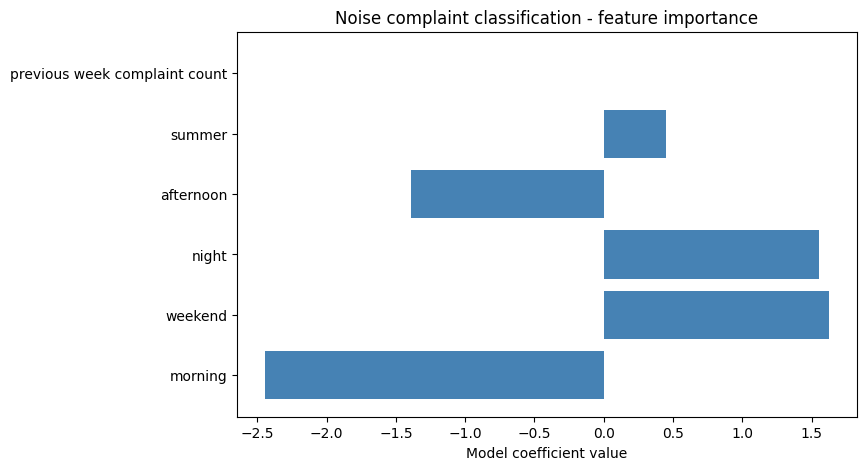

In [31]:
visualizations.get_log_odds_graph(loaded_model['model'])

## Summary and recommendation

<div class="summary">
Visual inspections of the 311 call data identified that more noise complaints tend to happen on nights, weekends, and summer days. The results from the logisitc regression confirm these patterns. My recommendation is that NYC prioritizes allocating more police officers to the Bronx on nights, weekends, and during the summer as these features have the ability to predict times with significant noise complaints. Staffing the officers on these days could potentially reduce the number of 311 calls as they would be able to address the noise issues more immediately. 
</div>